#**Evaluation of UML Algorithms**



In this notebook, we explore two major aspects of **unsupervised machine learning** evaluation and analysis:

1. **Clustering Metrics**: We generate synthetic data to demonstrate various internal and external clustering metrics such as **Silhouette Score**, **Davies-Bouldin Index**, **Dunn Index**, **Adjusted Rand Index**, and **Normalized Mutual Information**. These metrics help us understand the quality of clustering when the ground truth is known or unknown.

2. **Market Basket Analysis**: We create synthetic transactional data and use the **Apriori** algorithm to discover frequent itemsets and association rules. We then interpret these rules using metrics like **Support**, **Confidence**, **Lift**, **Leverage**, and **Conviction**.

By the end of this notebook, you will:
- Understand how to evaluate clustering performance with multiple metrics.  
- Be able to generate and interpret market basket association rules from transactional data.  
- Have practical examples showcasing how to visualize and compare different unsupervised learning outcomes.

---

##🔗 **Library Overview**

In this lab, we leverage the following Python libraries:

- **NumPy** ([Documentation](https://numpy.org/doc/)):  
  For numerical computations and array manipulations.

- **Pandas** ([Documentation](https://pandas.pydata.org/docs/)):  
  For handling and analyzing tabular data.

- **Matplotlib** ([Documentation](https://matplotlib.org/stable/)) and **Seaborn** ([Documentation](https://seaborn.pydata.org/)):  
  For data visualization (scatter plots, line charts, subplots, etc.).

- **Scikit-learn** ([Documentation](https://scikit-learn.org/stable/index.html)):  
  For generating synthetic datasets (`make_blobs`), performing clustering (`KMeans`), and evaluating clustering with various metrics (Silhouette, Davies-Bouldin, ARI, NMI).

- **SciPy** ([Documentation](https://docs.scipy.org/doc/scipy/reference/)):  
  Specifically `pdist` and `squareform` for distance matrix calculations (used in the Dunn Index).

- **mlxtend.frequent_patterns** ([Documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)):  
  For performing market basket analysis with the **Apriori** algorithm and generating association rules.

We also rely on **random seeding** (`np.random.seed(42)`) to ensure reproducible results in both the clustering demonstrations and transactional data generation.


##**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial.distance import pdist, squareform
from mlxtend.frequent_patterns import apriori, association_rules

# Set random seed for reproducibility
np.random.seed(42)


**Explanation**

This cell imports the necessary libraries and modules:

- **NumPy** and **Pandas** for data manipulation.
- **Matplotlib** and **Seaborn** for data visualization.
- **Scikit-learn** for generating synthetic data, clustering, and evaluating metrics.
- **SciPy** for distance calculations.
- **mlxtend.frequent_patterns** for association rule mining (Apriori and association rules).

We also set `np.random.seed(42)` for reproducibility.


##**Clustering – Data Generation and Dunn Index**

In [2]:
#####################################
# Part 1: Clustering Metrics Demo
#####################################

def generate_clusters(n_samples=500, n_features=2, centers=4, cluster_std=1.0):
    """Generate synthetic clustered data"""
    X, y_true = make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=centers,
        cluster_std=cluster_std,
        random_state=42
    )
    return X, y_true

def dunn_index(X, labels):
    """
    Calculate Dunn Index: ratio of the minimum inter-cluster distance
    to the maximum intra-cluster distance
    """
    # Calculate pairwise distance matrix
    dist_matrix = squareform(pdist(X, metric='euclidean'))

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Calculate minimum inter-cluster distance
    min_inter_cluster_dist = float('inf')
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i_indices = np.where(labels == unique_labels[i])[0]
            cluster_j_indices = np.where(labels == unique_labels[j])[0]

            # Get distances between points in different clusters
            inter_cluster_dists = dist_matrix[np.ix_(cluster_i_indices, cluster_j_indices)]
            min_dist = np.min(inter_cluster_dists)

            if min_dist < min_inter_cluster_dist:
                min_inter_cluster_dist = min_dist

    # Calculate maximum intra-cluster distance
    max_intra_cluster_dist = 0
    for i in range(n_clusters):
        cluster_indices = np.where(labels == unique_labels[i])[0]
        if len(cluster_indices) <= 1:
            continue

        # Get distances between points within the same cluster
        intra_cluster_dists = dist_matrix[np.ix_(cluster_indices, cluster_indices)]
        max_dist = np.max(intra_cluster_dists)

        if max_dist > max_intra_cluster_dist:
            max_intra_cluster_dist = max_dist

    # Calculate Dunn Index
    if max_intra_cluster_dist == 0:
        return float('inf')  # Avoid division by zero

    return min_inter_cluster_dist / max_intra_cluster_dist


**Explanation:**

- **`generate_clusters`**: Creates a synthetic dataset for clustering with a given number of samples, features, centers (clusters), and standard deviation.
- **`dunn_index`**: Calculates the **Dunn Index**, the ratio of the minimum distance between clusters to the maximum distance within clusters. Higher Dunn values indicate better clustering.


##**Evaluating Clustering and Visualizing Metrics**

In [3]:
def evaluate_clustering(X, y_true, cluster_range=(2, 7)):
    """Evaluate different clustering configurations using various metrics"""
    results = {
        'n_clusters': [],
        'silhouette': [],
        'davies_bouldin': [],
        'dunn': [],
        'ari': [],
        'nmi': []
    }

    for n_clusters in range(cluster_range[0], cluster_range[1]):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        y_pred = kmeans.fit_predict(X)

        silhouette = silhouette_score(X, y_pred)
        dbi = davies_bouldin_score(X, y_pred)
        dunn_val = dunn_index(X, y_pred)
        ari = adjusted_rand_score(y_true, y_pred)
        nmi = normalized_mutual_info_score(y_true, y_pred)

        results['n_clusters'].append(n_clusters)
        results['silhouette'].append(silhouette)
        results['davies_bouldin'].append(dbi)
        results['dunn'].append(dunn_val)
        results['ari'].append(ari)
        results['nmi'].append(nmi)

    return pd.DataFrame(results)

def visualize_clusters_and_metrics(X, results):
    """Visualize clusters and metrics for different cluster configurations"""
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    best_n_clusters = results.loc[results['silhouette'].idxmax(), 'n_clusters']
    kmeans = KMeans(n_clusters=int(best_n_clusters), random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X)

    scatter = axs[0, 0].scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
    axs[0, 0].set_title(f'Clustered Data (K={int(best_n_clusters)})')
    axs[0, 0].set_xlabel('Feature 1')
    axs[0, 0].set_ylabel('Feature 2')
    plt.colorbar(scatter, ax=axs[0, 0], label='Cluster')

    axs[0, 1].plot(results['n_clusters'], results['silhouette'], marker='o')
    axs[0, 1].set_title('Silhouette Score\n(Higher is better)')
    axs[0, 1].set_xlabel('Number of clusters')
    axs[0, 1].grid(True)

    axs[0, 2].plot(results['n_clusters'], results['davies_bouldin'], marker='o')
    axs[0, 2].set_title('Davies-Bouldin Index\n(Lower is better)')
    axs[0, 2].set_xlabel('Number of clusters')
    axs[0, 2].grid(True)

    axs[1, 0].plot(results['n_clusters'], results['dunn'], marker='o')
    axs[1, 0].set_title('Dunn Index\n(Higher is better)')
    axs[1, 0].set_xlabel('Number of clusters')
    axs[1, 0].grid(True)

    axs[1, 1].plot(results['n_clusters'], results['ari'], marker='o')
    axs[1, 1].set_title('Adjusted Rand Index\n(Higher is better)')
    axs[1, 1].set_xlabel('Number of clusters')
    axs[1, 1].grid(True)

    axs[1, 2].plot(results['n_clusters'], results['nmi'], marker='o')
    axs[1, 2].set_title('Normalized Mutual Information\n(Higher is better)')
    axs[1, 2].set_xlabel('Number of clusters')
    axs[1, 2].grid(True)

    plt.tight_layout()
    plt.show()


**Explanation:**

- **`evaluate_clustering`**:  
  Runs KMeans for each \(k\) in `cluster_range` and computes various metrics (Silhouette, Davies-Bouldin, Dunn, ARI, NMI).  
- **`visualize_clusters_and_metrics`**:  
  Plots those metrics vs. number of clusters and shows a scatter plot of the data clustered with the best Silhouette score.


##**Explaining Clustering Metrics**

In [4]:
def explain_clustering_metrics():
    """Print explanations for clustering metrics"""
    print("\n" + "="*80)
    print("CLUSTERING METRICS EXPLAINED".center(80))
    print("="*80 + "\n")

    metrics = {
        "Silhouette Score": (
            "Measures how similar an object is to its own cluster compared to other clusters. "
            "Ranges from -1 to 1, where higher values indicate better cluster separation."
        ),
        "Davies-Bouldin Index": (
            "Calculates the average similarity ratio of each cluster with its most similar cluster. "
            "Lower values indicate better clustering."
        ),
        "Dunn Index": (
            "Ratio of the minimum inter-cluster distance to the maximum intra-cluster distance. "
            "Higher values indicate better clustering with compact and well-separated clusters."
        ),
        "Adjusted Rand Index": (
            "Measures the similarity between the clustering result and the ground truth. "
            "Ranges from -1 to 1, where 1 indicates perfect agreement."
        ),
        "Normalized Mutual Information": (
            "Measures the mutual information between the clustering result and the ground truth, "
            "normalized by the average entropy. Ranges from 0 to 1, where 1 indicates perfect agreement."
        )
    }

    for metric, explanation in metrics.items():
        print(f"{metric}:")
        print(f"    {explanation}")
        print()


**Explanation:**

- **`explain_clustering_metrics`**: Prints definitions and interpretations of each clustering metric:
  - **Silhouette Score**
  - **Davies-Bouldin Index**
  - **Dunn Index**
  - **Adjusted Rand Index**
  - **Normalized Mutual Information**


##**Market Basket Analysis – Generating Transaction Data**

In [5]:
#####################################
# Part 2: Market Basket Analysis Demo
#####################################

def generate_transaction_data(n_transactions=1000, n_items=10, item_density=0.1):
    """Generate synthetic transaction data for market basket analysis"""
    transactions = np.random.binomial(1, item_density, size=(n_transactions, n_items))
    item_names = [f'item_{i}' for i in range(n_items)]
    df = pd.DataFrame(transactions, columns=item_names)

    # Inject some association patterns
    df.loc[df['item_0'] == 1, 'item_1'] = np.random.binomial(
        1, 0.8, size=df.loc[df['item_0'] == 1].shape[0]
    )
    df.loc[(df['item_2'] == 1) & (df['item_3'] == 1), 'item_4'] = np.random.binomial(
        1, 0.9, size=df.loc[(df['item_2'] == 1) & (df['item_3'] == 1)].shape[0]
    )

    return df


**Explanation:**

- **`generate_transaction_data`**:  
  Creates a synthetic DataFrame of transactions (binary purchase data).  
  - `item_density` controls the base probability of purchasing each item.
  - Injects realistic correlations (e.g., if `item_0` is purchased, there's a high chance `item_1` is also purchased) to simulate real-world shopping patterns.


##**Performing Market Basket Analysis**

In [6]:
def perform_market_basket_analysis(df, min_support=0.01, min_threshold=1):
    """Perform market basket analysis and calculate metrics"""
    # Run apriori algorithm to find frequent itemsets
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_threshold)

    # Calculate additional metrics if not already in the DataFrame
    if 'leverage' not in rules.columns:
        rules['leverage'] = rules.apply(
            lambda x: x['support'] - (x['antecedent support'] * x['consequent support']),
            axis=1
        )

    if 'conviction' not in rules.columns:
        rules['conviction'] = rules.apply(
            lambda x: (1 - x['consequent support']) / (1 - x['confidence'])
            if x['confidence'] < 1 else float('inf'),
            axis=1
        )

    return frequent_itemsets, rules


**Explanation:**

- **`perform_market_basket_analysis`**:
  1. Applies the **Apriori** algorithm to find frequent itemsets given `min_support`.
  2. Uses **`association_rules`** to discover rules with a `lift` metric threshold (`min_threshold`).
  3. Adds **leverage** and **conviction** if they are not already present in the rules.

Returns the frequent itemsets and the resulting association rules.


##**Visualizing Association Rules**

In [7]:
def visualize_association_rules(rules):
    """Visualize association rules metrics"""
    if len(rules) == 0:
        print("No association rules found with the current thresholds.")
        return

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Scatter plot of support vs confidence
    scatter1 = axs[0, 0].scatter(rules['support'], rules['confidence'],
                                 c=rules['lift'], cmap='viridis', alpha=0.7)
    axs[0, 0].set_title('Support vs Confidence')
    axs[0, 0].set_xlabel('Support')
    axs[0, 0].set_ylabel('Confidence')
    plt.colorbar(scatter1, ax=axs[0, 0], label='Lift')

    # Scatter plot of lift vs confidence
    scatter2 = axs[0, 1].scatter(rules['lift'], rules['confidence'],
                                 c=rules['support'], cmap='plasma', alpha=0.7)
    axs[0, 1].set_title('Lift vs Confidence')
    axs[0, 1].set_xlabel('Lift')
    axs[0, 1].set_ylabel('Confidence')
    plt.colorbar(scatter2, ax=axs[0, 1], label='Support')

    # Scatter plot of leverage vs lift
    scatter3 = axs[1, 0].scatter(rules['leverage'], rules['lift'],
                                 c=rules['confidence'], cmap='inferno', alpha=0.7)
    axs[1, 0].set_title('Leverage vs Lift')
    axs[1, 0].set_xlabel('Leverage')
    axs[1, 0].set_ylabel('Lift')
    plt.colorbar(scatter3, ax=axs[1, 0], label='Confidence')

    # Scatter plot of conviction vs confidence
    rules_finite = rules[rules['conviction'] < float('inf')].copy()
    if len(rules_finite) > 0:
        scatter4 = axs[1, 1].scatter(rules_finite['conviction'], rules_finite['confidence'],
                                     c=rules_finite['lift'], cmap='cividis', alpha=0.7)
        axs[1, 1].set_title('Conviction vs Confidence')
        axs[1, 1].set_xlabel('Conviction')
        axs[1, 1].set_ylabel('Confidence')
        plt.colorbar(scatter4, ax=axs[1, 1], label='Lift')
    else:
        axs[1, 1].text(0.5, 0.5, "No rules with finite conviction",
                       horizontalalignment='center', verticalalignment='center')
        axs[1, 1].set_title('Conviction vs Confidence')

    plt.tight_layout()
    plt.show()


**Explanation:**

- **`visualize_association_rules`**:
  - Creates scatter plots for different pairs of metrics (Support, Confidence, Lift, Leverage, Conviction).
  - Color-coding allows quick interpretation of how these metrics interact.
  - If no rules are found or if conviction is infinite, the code handles it gracefully.


##**Explaining Market Basket Analysis Metrics**

In [8]:
def explain_market_basket_metrics():
    """Print explanations for market basket analysis metrics"""
    print("\n" + "="*80)
    print("MARKET BASKET ANALYSIS METRICS EXPLAINED".center(80))
    print("="*80 + "\n")

    metrics = {
        "Support": (
            "The proportion of transactions that contain both the antecedent and consequent items. "
            "Support(A→B) = Frequency(A,B) / N"
        ),
        "Confidence": (
            "The probability of finding the consequent in transactions given that these transactions "
            "contain the antecedent. Confidence(A→B) = Support(A→B) / Support(A)"
        ),
        "Lift": (
            "The ratio of the observed support to the expected support if the antecedent and consequent "
            "were independent. Lift(A→B) = Support(A→B) / (Support(A) * Support(B))"
        ),
        "Leverage": (
            "The difference between the observed joint probability of the antecedent and consequent "
            "and the expected joint probability if they were independent."
        ),
        "Conviction": (
            "The ratio of the expected frequency of the antecedent occurring without the consequent "
            "to the observed frequency. (1 - Support(B)) / (1 - Confidence(A→B))"
        )
    }

    for metric, explanation in metrics.items():
        print(f"{metric}:")
        print(f"    {explanation}")
        print()


**Explanation:**
- **`explain_market_basket_metrics`**: Prints short definitions of the main metrics used in association rules:
  - **Support**
  - **Confidence**
  - **Lift**
  - **Leverage**
  - **Conviction**


##**Displaying Top Rules**

In [9]:
def display_top_rules(rules, n=10):
    """Display top association rules based on different metrics"""
    if len(rules) == 0:
        print("No association rules found with the current thresholds.")
        return

    print("\n" + "="*80)
    print("TOP ASSOCIATION RULES".center(80))
    print("="*80 + "\n")

    metrics = ['support', 'confidence', 'lift', 'leverage', 'conviction']

    for metric in metrics:
        print(f"\nTop {n} rules by {metric}:")

        if metric == 'conviction':
            finite_rules = rules[rules['conviction'] < float('inf')].nlargest(min(n, len(rules)), metric)
            if len(finite_rules) > 0:
                formatted_rules = format_rules(finite_rules)
                for i, rule in enumerate(formatted_rules, 1):
                    print(f"{i}. {rule}")

            inf_rules = rules[rules['conviction'] == float('inf')]
            if len(inf_rules) > 0:
                print("\nRules with infinite conviction (confidence = 1):")
                formatted_inf_rules = format_rules(inf_rules.head(min(n, len(inf_rules))))
                for i, rule in enumerate(formatted_inf_rules, 1):
                    print(f"{i}. {rule}")
        else:
            top_rules = rules.nlargest(min(n, len(rules)), metric)
            formatted_rules = format_rules(top_rules)
            for i, rule in enumerate(formatted_rules, 1):
                print(f"{i}. {rule}")

def format_rules(rules):
    """Format association rules for display"""
    formatted_rules = []
    for _, rule in rules.iterrows():
        antecedent = ', '.join([f"'{item}'" for item in list(rule['antecedents'])])
        consequent = ', '.join([f"'{item}'" for item in list(rule['consequents'])])

        formatted_rule = f"{{{antecedent}}} → {{{consequent}}}"
        formatted_rule += f" [Support={rule['support']:.4f}, Confidence={rule['confidence']:.4f}, "
        formatted_rule += f"Lift={rule['lift']:.4f}, Leverage={rule['leverage']:.4f}, "

        if rule['conviction'] == float('inf'):
            formatted_rule += "Conviction=∞]"
        else:
            formatted_rule += f"Conviction={rule['conviction']:.4f}]"

        formatted_rules.append(formatted_rule)

    return formatted_rules


**Explanation:**

- **`display_top_rules`**:  
  - Sorts rules by various metrics (support, confidence, lift, leverage, conviction) and displays the top \(n\).  
  - Handles infinite conviction rules (confidence = 1) separately.  

- **`format_rules`**:  
  - Converts each rule into a more readable string, including item sets and metric values.


##**Main Execution**


********************************************************************************
                 UNSUPERVISED LEARNING EVALUATION METRICS DEMO                  
********************************************************************************



PART 1: CLUSTERING METRICS DEMO
----------------------------------------

Generating synthetic clustered data...

Evaluating clustering with different numbers of clusters...

Clustering Evaluation Results:
 n_clusters  silhouette  davies_bouldin   dunn    ari    nmi
          2      0.5955          0.5196 0.4794 0.3320 0.5772
          3      0.7613          0.3486 0.4275 0.7131 0.8571
          4      0.7911          0.2939 0.3413 1.0000 1.0000
          5      0.6633          0.6452 0.0287 0.9161 0.9428
          6      0.5613          0.8419 0.0287 0.8230 0.8911

                          CLUSTERING METRICS EXPLAINED                          

Silhouette Score:
    Measures how similar an object is to its own cluster compared to other clust

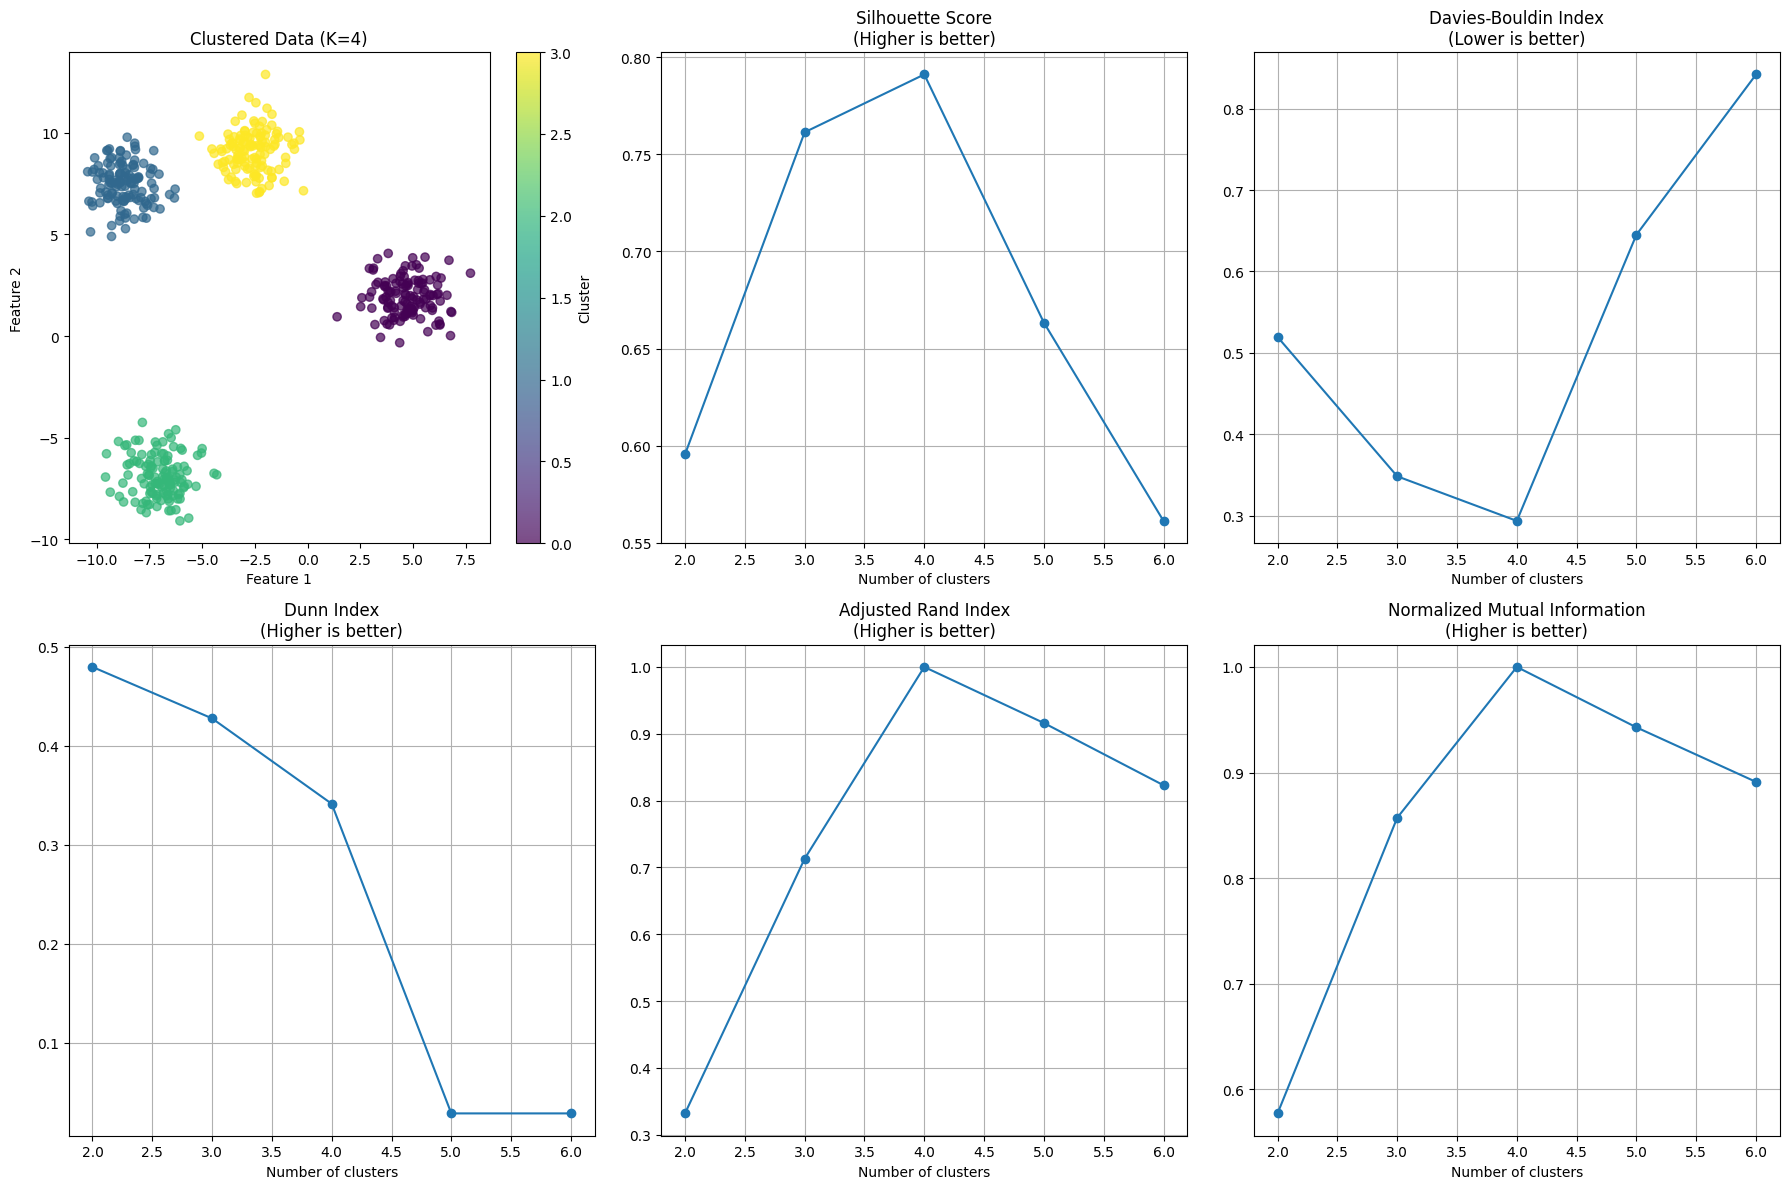



PART 2: MARKET BASKET ANALYSIS DEMO
----------------------------------------

Generating synthetic transaction data...

Sample of transaction data:
   item_0  item_1  item_2  item_3  item_4  item_5  item_6  item_7  item_8  \
0       0       1       0       0       0       0       0       0       0   
1       0       1       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       1       1       0       0       0       0   
4       0       0       0       1       0       0       0       0       0   

   item_9  
0       0  
1       0  
2       0  
3       0  
4       0  

Item frequencies:
  item_1: 171 (0.1710)
  item_4: 107 (0.1070)
  item_8: 104 (0.1040)
  item_5: 104 (0.1040)
  item_6: 100 (0.1000)
  item_2: 100 (0.1000)
  item_0: 89 (0.0890)
  item_7: 88 (0.0880)
  item_3: 87 (0.0870)
  item_9: 81 (0.0810)

Performing market basket analysis...

Sample of frequent itemsets:
 s

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


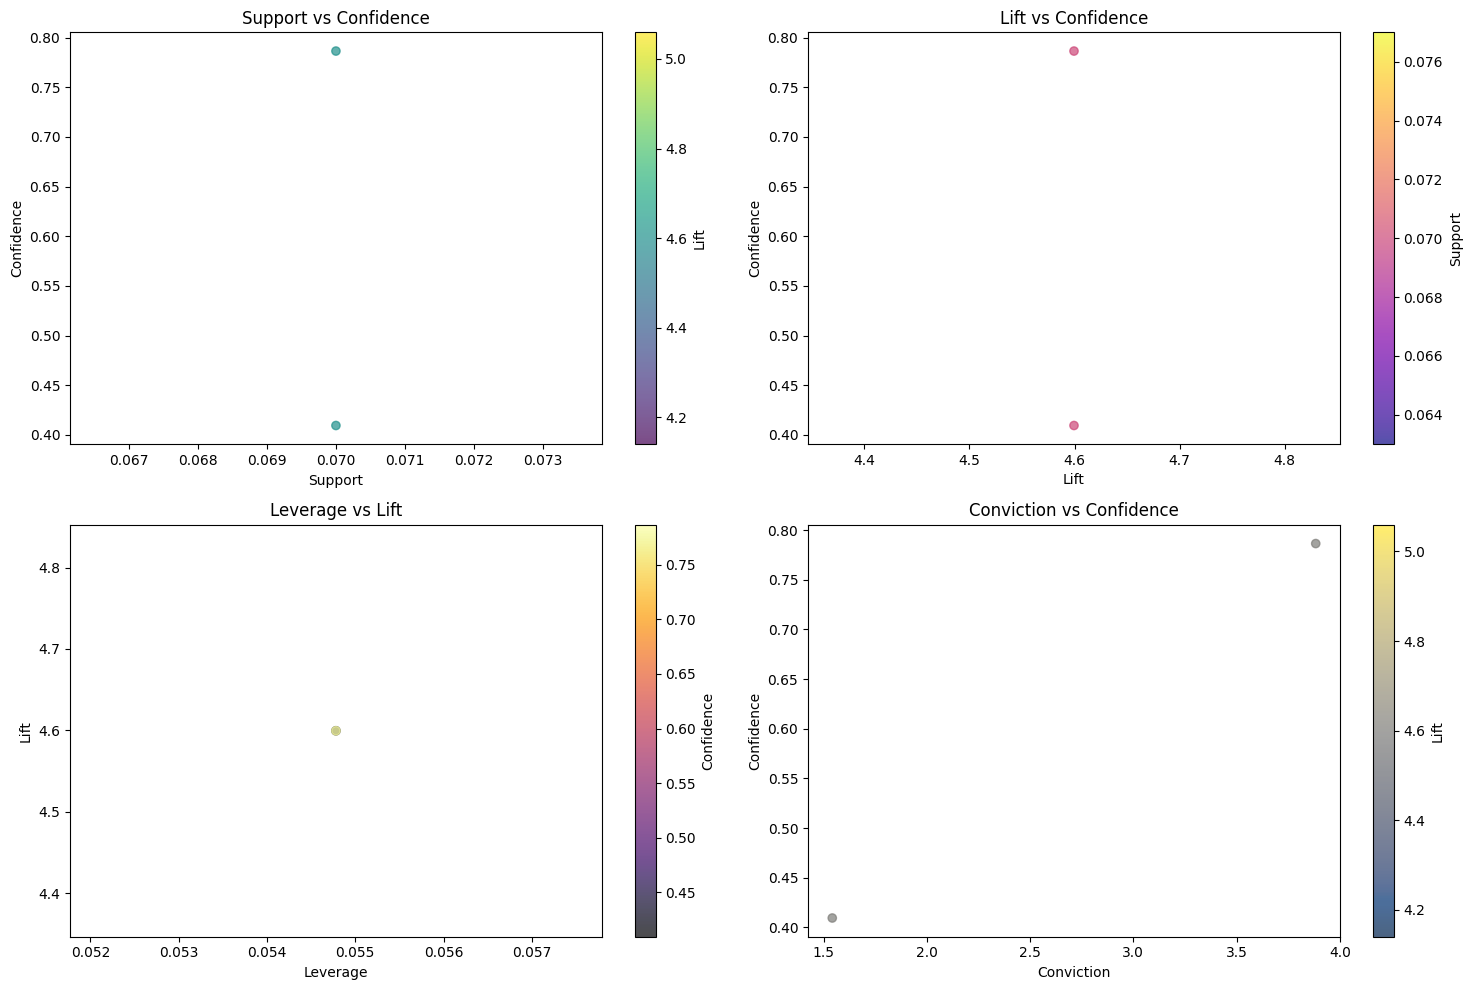


********************************************************************************
                                 DEMO COMPLETED                                 
********************************************************************************



In [10]:
#####################################
# Main Execution
#####################################

def main():
    print("\n" + "*"*80)
    print("UNSUPERVISED LEARNING EVALUATION METRICS DEMO".center(80))
    print("*"*80 + "\n")

    # Part 1: Clustering Metrics Demo
    print("\n\nPART 1: CLUSTERING METRICS DEMO")
    print("-"*40 + "\n")

    # Generate synthetic data with clusters
    print("Generating synthetic clustered data...\n")
    X, y_true = generate_clusters(n_samples=500, centers=4, cluster_std=1.0)

    # Evaluate clustering with different numbers of clusters
    print("Evaluating clustering with different numbers of clusters...\n")
    results = evaluate_clustering(X, y_true, cluster_range=(2, 7))

    # Print results table
    print("Clustering Evaluation Results:")
    print(results.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # Explain metrics
    explain_clustering_metrics()

    # Create visualizations
    print("\nCreating visualizations for clustering metrics...")
    visualize_clusters_and_metrics(X, results)

    # Part 2: Market Basket Analysis Demo
    print("\n\nPART 2: MARKET BASKET ANALYSIS DEMO")
    print("-"*40 + "\n")

    # Generate transaction data
    print("Generating synthetic transaction data...\n")
    transactions_df = generate_transaction_data(n_transactions=1000, n_items=10, item_density=0.1)

    # Show sample of transactions
    print("Sample of transaction data:")
    print(transactions_df.head())

    # Calculate item frequencies
    print("\nItem frequencies:")
    item_frequencies = transactions_df.sum().sort_values(ascending=False)
    for item, freq in item_frequencies.items():
        print(f"  {item}: {freq} ({freq/len(transactions_df):.4f})")

    # Perform market basket analysis
    print("\nPerforming market basket analysis...")
    frequent_itemsets, rules = perform_market_basket_analysis(transactions_df,
                                                             min_support=0.03,
                                                             min_threshold=1)

    # Show frequent itemsets
    print("\nSample of frequent itemsets:")
    if len(frequent_itemsets) > 0:
        print(frequent_itemsets.head(10).to_string(index=False))
    else:
        print("No frequent itemsets found with the current support threshold.")

    # Show association rules
    print("\nSample of association rules:")
    if len(rules) > 0:
        display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', 'conviction']
        print(rules[display_cols].head(10).to_string(index=False))
    else:
        print("No association rules found with the current thresholds.")

    # Display top rules by different metrics
    display_top_rules(rules, n=5)

    # Explain metrics
    explain_market_basket_metrics()

    # Create visualizations
    print("\nCreating visualizations for association rules...")
    visualize_association_rules(rules)

    print("\n" + "*"*80)
    print("DEMO COMPLETED".center(80))
    print("*"*80 + "\n")

main()


**Explanation:**

- The **`main()`** function orchestrates the entire demo:
  1. **Clustering Metrics Demo**:  
     - Generates synthetic cluster data  
     - Evaluates clustering performance for different \(k\)  
     - Prints and visualizes results  
  2. **Market Basket Analysis Demo**:  
     - Generates synthetic transaction data  
     - Finds frequent itemsets  
     - Prints, visualizes, and explains association rules  
  3. **Runs** all functions end-to-end for a comprehensive demonstration.


## 📚**Additional Reading & Resources**

Below are some recommended resources to deepen your understanding:

1. **Clustering Metrics**:
   - [Scikit-learn: Clustering Metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)  
     Official documentation for clustering algorithms and evaluation metrics.
   - [A Practical Guide to Cluster Analysis in R](https://uc-r.github.io/kmeans_clustering)  
     Although it's R-focused, the explanations of clustering concepts and metrics apply to Python as well.

2. **Market Basket Analysis**:
   - [Mlxtend Apriori Documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)  
     Explains the parameters for the apriori function and shows additional examples.
   - [Association Rules in Python](https://pbpython.com/market-basket-analysis.html)  
     A blog post demonstrating how to generate and interpret association rules.

3. **General Machine Learning**:
   - [Elements of Statistical Learning (Hastie, Tibshirani, Friedman)](https://web.stanford.edu/~hastie/ElemStatLearn/)  
     A classic reference covering both supervised and unsupervised learning methods.
   - [Introduction to Machine Learning with Python (O’Reilly)](https://www.oreilly.com/library/view/introduction-to-machine/9781449369880/)  
     Offers practical code examples and focuses on scikit-learn.


##🔗 **Relevant Kaggle Notebooks**

For additional hands-on practice, consider exploring these publicly available Kaggle notebooks:

### **1. Clustering**
- **[K-Means Clustering with Python](https://www.kaggle.com/code/prashant111/k-means-clustering-with-python)**  
  This notebook provides a comprehensive guide to K-Means clustering, including data preprocessing, model building, and visualization.

- **[Step by Step KMeans Explained in Detail](https://www.kaggle.com/code/shrutimechlearn/step-by-step-kmeans-explained-in-detail)**  
  A detailed walkthrough of the K-Means algorithm, explaining each step with code and visualizations.

### **2. Market Basket Analysis**
- **[Market Basket Analysis using Apriori Algorithm](https://www.kaggle.com/code/priy998/market-basket-analysis-using-apriori-algorithm)**  
  This notebook demonstrates how to perform market basket analysis using the Apriori algorithm to uncover relationships between items.

- **[Market Basket Analysis with Apriori Algorithm](https://www.kaggle.com/code/prasad22/market-basket-analysis-with-apriori-algorithm)**  
  An insightful notebook on implementing the Apriori algorithm for market basket analysis, including data preprocessing and rule interpretation.

Feel free to explore, fork, and adapt these notebooks based on your specific use case or dataset.


## **Optional / Advanced Topics**

- **Alternative Clustering Algorithms**: Beyond KMeans, explore algorithms like **DBSCAN** (density-based) or **Agglomerative Clustering** (hierarchical). Each has different strengths and may require unique metrics (e.g., **Calinski-Harabasz**, **CH Index**).

- **Dimensionality Reduction**: Techniques like **PCA** (Principal Component Analysis) or **t-SNE** (t-Distributed Stochastic Neighbor Embedding) can help visualize high-dimensional data before or after clustering.

- **Hyperparameter Tuning**: While KMeans mainly tunes the number of clusters **k**, other algorithms (like DBSCAN) have parameters such as **epsilon** and **min_samples** that significantly affect clustering outcomes.

- **Other Association Rule Mining Algorithms**:
  - **FP-Growth**: Often faster than Apriori for large datasets.  
  - **Eclat**: Uses a vertical database format for potentially faster itemset generation.

- **Production Considerations**: In real-world systems, consider online updating of clusters (streaming data) or incremental updating of association rules (to adapt to changing purchase patterns).

Feel free to dive deeper into any of these advanced topics as you progress.
